In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.integrate as integrate
from scipy.optimize import minimize_scalar

# Dobly Differential Cross Section for Electron Scattered by Nitrogen
## J. C. Nogueira, M. A. Eschiapati Ferreira and Ronaldo S. Barbieri

In [3]:
# Parameters from table 1
A1 = 0.3
A2 = 0.45
A3 = -2.0
A4 = 3.0
n = 2.13
G5 = 0.33
beta = 1.0
gamma = 10.0

# Parameters from figure 1
#A1 = 0.275
#A2 = 0.75
#A3 = -2.0
#A4 = 3.0
#n = 2.86
#G5 = 0.33
#beta = 0.60
#gamma = 10.0

# Other parameters
I_ion = 15.6 # [eV]

The equation for the cross section is
$$\sigma(w, t, \theta) = G_1 \left[ f_{BE}(w, t, \theta) + G_2 f_b (w, t, \theta) \right]$$
where
$$G_1 = \left[ SF(t)f_1 (w, t)/I_{ion} \right] / \left[ g_{BE}(w, t) + G_2 g_b (w, t) \right]$$
$$f_{BE}(w, t, \theta) = 1 / \left\{ 1 + \left[ (cos\theta - G_3)/G_4 \right]^2 \right\}$$
$$f_b (w, t, \theta) = 1 / \left\{ 1 + \left[ (cos\theta + 1)/G_5 \right]^2 \right\}$$
and
$$F(t) = A_1 Int/t + A_2(t + A_4) + A_3/t^2 $$
The function above seems strange $Int/t$ ?? Check the reference in the paper.
$$ f_1(w, t) = \left[1/(w+1)^n\right] + \left[ 1/(t-w)^n \right] - \left[ 1/((w+1)(t-w))^{n/2} \right]$$
other parameters
$$g_{BE} = 2\pi G_4 \left\{ \tan^{-1}\left[(1-G_3)/G_4 \right] + \tan^{-1}\left[(1+G_3)/G_4 \right] \right\}$$
$$g_b = 2\pi G_5 \tan^{-1}(2/G_5)$$
$$G_2 = \gamma \left\{ \left[ 1 - (w/t) \right]^3/\left[t(w+1)\right] \right\}$$
$$G_3 = \left[ (w+1)/t \right]^{1/2}$$
$$G_4 = \beta \left[(1-G_3^2)/2 \right]^{1/2}$$

In [4]:
g_b = 2*np.pi*G5*np.arctan(2/G5)

def Cross(w, t, theta):
    res = G_1(w, t)*(f_BE(w, t, theta) + G_2(w, t)*f_b(w, t, theta))
    return res

def G_1(w, t):
    #a_0 = 5.2917721067E-11 # Bohr radius [m]
    a_0 = 5.2917721067
    N = 14 # 1 molecule of N2 has 14 electrons
    R = 13.6 # eV
    S = 4*np.pi*a_0**2*N*(R/I_ion)**2
    
    res = (S*F(t)*f_1(w, t)/I_ion)/(g_BE(w, t) + G_2(w, t)*g_b)
    return res

def f_BE(w, t, theta):
    res = 1/(1 + ((np.cos(theta) - G_3(w, t))/G_4(w, t))**2)
    return res

def f_b(w, t, theta):
    res = 1/(1 + ((np.cos(theta) + 1)/G5)**2)
    return res

def F(t):
    res = A1*np.log(t)/t + A2/(t + A4) + A3/t**2
    return res

def f_1(w, t):
    res = 1/(w+1)**n + 1/(t-w)**n - 1/((w+1)*(t-w))**(n/2)
    return res

def g_BE(w, t):
    res = 2*np.pi*G_4(w, t)*( np.arctan((1-G_3(w, t))/G_4(w, t))  + np.arctan((1+G_3(w, t))/G_4(w, t)) )
    return res

def G_2(w, t):
    res = gamma*((1-(w/t))**3/(t*(w+1)))
    return res

def G_3(w, t):
    res = np.sqrt((w+1)/t)
    return res

def G_4(w, t):
    res = beta*np.sqrt((1-G_3(w, t)**2)/w)
    return res    

In [94]:
W = 20.0 # Ejected-electron energy [eV]
T = 5000 # Primary energy [eV]
angle = np.linspace(0.0, 180.0, 1001) # Angle [deg]
#angle = np.pi/2.0

data = Cross(W/I_ion, T/I_ion, angle*np.pi/180)

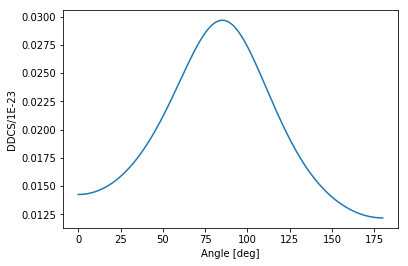

In [95]:
plt.plot(angle, data)
plt.xlabel('Angle [deg]')
plt.ylabel('DDCS/1E-23')
#plt.xlim([0, 180])
#plt.ylim([0, 11.0])
plt.show()

In [7]:
int_fun = lambda x: Cross(W/I_ion, T/I_ion, x*np.pi/180)
result = integrate.quad(int_fun, 0, 180, limit=5000, epsabs=0.5E-12, epsrel=0.5E-12)
result

(13.301215559614741, 1.9278082496434074e-13)

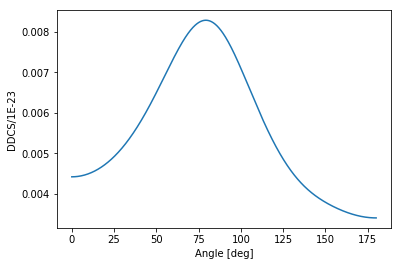

In [8]:
plt.plot(angle, data/result[0])
plt.xlabel('Angle [deg]')
plt.ylabel('DDCS/1E-23')
#plt.xlim([0, 180])
#plt.ylim([0, 11.0])
plt.show()

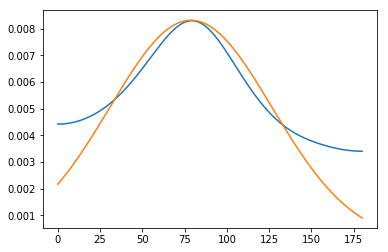

In [22]:
def Normaldist(mu, sigma, x):
    res = 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-(x-mu)**2/(2*sigma**2))
    return res

mu = 78.75
sigma = 48.0

normd = Normaldist(mu, sigma, angle)
plt.plot(angle, data/result[0], angle, normd)
plt.show()

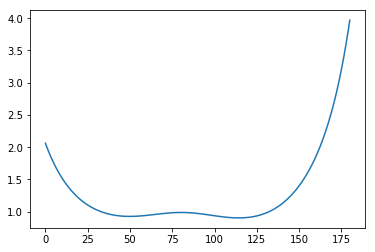

In [10]:
fdg = (data/result[0])/normd
plt.plot(angle, fdg)
plt.show()

In [174]:
np.max(fdg)

4.152473014455658

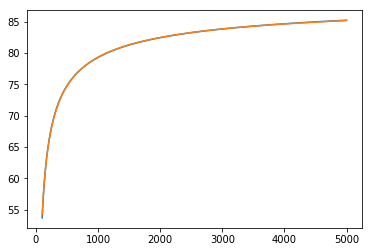

In [93]:
Angle_max = []
Energy = []
for E in range(100, 5000):
    min_fun = lambda x: -1.0*Cross(20/I_ion, E/I_ion, x*np.pi/180)
    res = minimize_scalar(min_fun, bounds=(0, 180), method='bounded')
    Angle_max.append(res.x)
    Energy.append(E)
    #print(res.x)
    #print(-1.0*min_fun(res.x))
    
eng = np.linspace(100, 5000, 1000)
a = -430.5
b = -0.5445
c = 89.32
test_f = a*eng**b + c
plt.plot(Energy, Angle_max)
plt.plot(eng, test_f)
plt.show()
#np.savetxt('data_e.txt', Energy)
#np.savetxt('data_angle.txt', Angle_max)

In [52]:
min_fun = lambda x: -1.0*Cross(W/I_ion, 572.0/I_ion, x*np.pi/180)
res = minimize_scalar(min_fun, bounds=(0, 180), method='bounded')
print(res.x)
print(-1.0*min_fun(res.x))

75.78214292712823
0.16553107245231022
